In [44]:
##This is for HF TC parameter caluclation
## Sung Chung

import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd
import math
from pandas.tools.plotting import andrews_curves
from scipy import interpolate
pd.set_option('display.max_columns', 500)
%matplotlib inline
num_dev=0
absMaxFld=13900            #****may need to slightly cut end of the testing field

###############################################
peakAtNegativeFld=-1        # if HF peak is at negative field +1, or -1(Tbd HF is -1)  
fltLeft=-3000
fltRight=4000
P1_BJ_Limit=500                # to decide if P1 result using BJ or max : if>500 use BJ
horn_define_Field=-4000        # to define horn area to 0 Oe 
horn_BJ=10                      #if horn is >10% amplitude range, H50 is from modified range (fltLeft)   
##################
directory= "C:\python"
filename='HF_QST258_Eval_PB_ A_WJ7C$C42D1_EX_12122015_R0512.Transverse.1.4T_0.0V_data'
####################
filepath=directory+"\\"+filename+".csv"
#____________________________________
DataFile=filename + "_DataTable.csv"
sumName=filename + "_Summary.csv"
sumf=directory+"\\"+sumName
dataf=directory+"\\"+DataFile

fhand = open(filepath)

#fline.write("ID,Field,Amp,Dir,Partition,Dev, \n")
Dev=[]
ID=[]
Fld=[]
Amp=[]

num_dev=0
for line in fhand:                       # line is string
    line=line.rstrip()
    
    if line[0]=="T":
        num_dev+=1
        
        
    elif (line[0:2]=="Hd" or line[0:2]=="SR"):
        colVal=line.split(",")        
        name=colVal[1]                      # name is string
        name=name[3:]                       # ID wafer+slider
        
    else:
        colVal=line.split(",")   
        fld=colVal[0]
        amp=colVal[1]
        
        Dev.append(num_dev)
        ID.append(name)
        Fld.append(fld)
        Amp.append(amp)
             
dfb=pd.DataFrame({'SR':ID,'Field':Fld,'Amp':Amp,'Dev':Dev})      
dfb[['Field','Amp']]=dfb[['Field','Amp']].astype(float)
dfb['ampDiff']=dfb.Amp.diff()
fhand.close()


In [45]:
dfb.Field=dfb.Field.apply(lambda x: x*peakAtNegativeFld)
dfb.tail()

,Amp,Dev,Field,SR,ampDiff
5605,-8519.151,5,13800.01,WJ7CF56H,-41.063
5606,-8552.004,5,13849.97,WJ7CF56H,-32.853
5607,-8576.646,5,13899.93,WJ7CF56H,-24.642
5608,-8609.498,5,13949.89,WJ7CF56H,-32.852
5609,-8593.082,5,13999.85,WJ7CF56H,16.416


In [46]:

dfb['fld_diff']=dfb.Field.diff()
dfb['absFld'] = dfb[['Field']].apply(lambda x: np.abs(x), axis=1)
dfb=dfb[dfb.absFld<absMaxFld]                            #absMaxFld=13900 
dfb=dfb.dropna()

dfb.head()

,Amp,Dev,Field,SR,ampDiff,fld_diff,absFld
2,-6811.810,1,13899.93,WJ7CF56M,-98.763,-49.96,13899.93
3,-6910.572,1,13849.97,WJ7CF56M,-98.762,-49.96,13849.97
4,-6927.221,1,13800.01,WJ7CF56M,-16.649,-49.96,13800.01
5,-6952.082,1,13750.06,WJ7CF56M,-24.861,-49.95,13750.06
6,-6894.830,1,13700.10,WJ7CF56M,57.252,-49.96,13700.10


In [47]:
def getf1f2(dfc):
    
    SR=[]   
    F1=[]
    F2=[]
 
    srlist=list(set(dfc.SR.tolist()))       
    dfg=dfc.groupby("SR")
   
    for hd in srlist:    
        b=dfg.get_group(hd)      
        
        b_fwd=b[b.fld_diff >0]
        b_fwd.reset_index(inplace=True)
        z1=b_fwd.absFld.argmin()
        f1=b_fwd.Field[z1]
             
        b_rev=b[b.fld_diff<=0]
        b_rev.sort_values(by='Field', inplace=True)
        b_rev.reset_index(inplace=True)
        z2=b_rev.absFld.argmin()
        f2=b_rev.Field[z2]
        
        SR.append(hd)
        F1.append(f1)
        F2.append(f2)
        
    dff=pd.DataFrame({'SR':SR,'f1':F1,'f2':F2})
    return dff 


In [48]:
def getDir(row):
    if row['fld_diff']>0 and row['Field']<= row['f1']:
        return 1
    if row['fld_diff']>=0 and row['Field']> row['f1']:
        return 2
    if row['fld_diff']<0 and row['Field']>= row['f2']:
        return 3
    if row['fld_diff']<=0 and row['Field']< row['f2']:
        return 4

In [49]:
dfc=getf1f2(dfb)
dfb=pd.merge(dfb,dfc,on='SR')
dfb['Partition']=dfb.apply (lambda x: getDir(x),axis=1)
dfb['Direction']=dfb.Partition.apply(lambda x: "fwd" if (x==1 or x==2) else 'rev')
dfb.to_csv(dataf)


c:\anaconda\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [50]:
from scipy import stats

# for butterfly calculation
def calSlope (grp):
    x=grp.Field
    y=grp.Amp
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return slope

def Butterfly(row):
    if (row['FwdSlope']>0 and row['RevSlope']<0):
        return 'PLR Butterfly'
    elif (row['FwdSlope']<0 and row['RevSlope']>0):
        return 'Butterfly'
    elif (row['FwdSlope']>0 and row['RevSlope']>0):
        return 'PLR'
    else:
        return 'Normal'
    
          
SR=[]
revSlope=[]
fwdSlope=[]


dfc=dfb[(dfb.Field>-1000) & (dfb.Field>-1000) ]
grouped=dfc.groupby(['SR','Direction'])

for srD, group in grouped:   
    if srD[1]=='fwd':
        SR.append(srD[0])
        fwdSlope.append(calSlope(group))
    else:
        revSlope.append(calSlope(group))
    
dfBF=pd.DataFrame({'SR':SR,'FwdSlope':fwdSlope, 'RevSlope':revSlope}) 
dfBF['Butterfly']=dfBF.apply(lambda x: Butterfly(x),axis=1)

dfBF.head()



,FwdSlope,RevSlope,SR,Butterfly
0,-0.394077,-0.234002,WJ7CF56H,Normal
1,-0.417003,-0.329897,WJ7CF56J,Normal
2,-0.356122,-0.242007,WJ7CF56K,Normal
3,-0.872172,-0.683761,WJ7CF56L,Normal
4,-0.381348,-0.266455,WJ7CF56M,Normal


In [51]:
#for H50 cal as original (no horn consideration)
grouped=dfb.groupby('SR')
ampmax=grouped.Amp.max()
ampmin=grouped.Amp.min()
ampH50=(ampmax+ampmin)/2
amprng=ampmax-ampmin
amprng=pd.DataFrame(amprng)
amprng.reset_index(inplace=True)
amprng.rename(columns={'Amp':'AmpRng'},inplace=True)
amprng.head()


,SR,AmpRng
0,WJ7CF56H,27552.160
1,WJ7CF56J,14889.455
2,WJ7CF56K,15392.429
3,WJ7CF56L,24739.763
4,WJ7CF56M,24849.435


In [52]:
# to calcualte horn
def P2Area(row):
    if (row['Partition']==1 or row['Partition']==4):
        if (row['Field']>horn_define_Field or row['Field']<0):
            return 'P2Area'

In [53]:
# to calcualte horn_ratio
dfc=dfb.loc[:,["SR","Field","Partition","ampDiff"] ]   
dfc['P2Area']=dfc.apply (lambda x: P2Area(x),axis=1)
dfc=dfc[dfc.P2Area== 'P2Area']
dfc.ampDiff=dfc.ampDiff.abs()
dfc=dfc.groupby("SR").ampDiff.max()
dfc=pd.DataFrame(dfc)
dfc.reset_index(inplace=True)
dfc=pd.merge(dfc, amprng, on='SR')
dfc['hornRatio']=(dfc.ampDiff)/(dfc.AmpRng)*100
dfc.head()


,SR,ampDiff,AmpRng,hornRatio
0,WJ7CF56H,5361.9600,27552.160,19.461124
1,WJ7CF56J,6273.4994,14889.455,42.133842
2,WJ7CF56K,993.5410,15392.429,6.454738
3,WJ7CF56L,9631.4810,24739.763,38.931177
4,WJ7CF56M,7283.6200,24849.435,29.311008


In [54]:
#for H50 cal by reduced field range to remove horn
dfbFilter=dfb[(dfb.Field>fltRight) |  (dfb.Field<fltLeft)]  
grouped=dfbFilter.groupby('SR')
ampmax_corr=grouped.Amp.max()
ampmin_corr=grouped.Amp.min()
ampH50_corr=(ampmax_corr+ampmin_corr)/2
print ampmax_corr

SR
WJ7CF56H    9769.796
WJ7CF56J    2792.616
WJ7CF56K    6113.999
WJ7CF56L   -3417.499
WJ7CF56M    8054.945
Name: Amp, dtype: float64


In [55]:
#cut off field to remove horn
dfh=dfbFilter.groupby(['SR','Partition'])
t=list(set(dfb.SR))

samplesize=len(t)                    #num of heads
SR=[]
H50A=[]                           #Filtered partition1
H50B=[]                           #Filtered partition4
H50A_m=[]                        #real max   partition1 including horn
H50B_m=[]                        #real max   partition4 including horn

FlddAmpMax2=[]       #field of amp DELTA max at partition2 for P1 field calculation (BJ like)
FlddAmpMax3=[]       #field of amp DELTA max at partition3 for P1 field calculation (BJ like)
dAmp_max_Jmp_2=[]    # amplitude of FlddAmpMax2=[] (BJ like)

max_in_2=[]            
max_in_3=[]

FldAmpMax2=[]      # field of amp max at partition2 for P1 field calculation      
FldAmpMax3=[]      # field of amp max at partition2 for P1 field calculation  




for srPat, grp in dfh:                       # dfh is filtered
    sr=srPat[0]                              #srPat is tuple example: ('53',1)
    yToFind=ampH50_corr[sr]                   #excluded center part of the HF, amplitude
    yToFind_m=ampH50[sr]                      #from real max, amplitude   
    
 
     #      *************** partition 1 
    if srPat[1]==1:
        g=grp.sort_values(by='Field',ascending=True)
 
        x1=g.Field      
        y1=g.Amp  

        yreduced = y1 - yToFind
        yreduced_m = y1 - yToFind_m
        freduced = interpolate.UnivariateSpline(x1, yreduced, s=0)
        freduced_m = interpolate.UnivariateSpline(x1, yreduced_m, s=0)
        rt=freduced.roots().mean()
        rt_m=freduced_m.roots().mean()
        SR.append(sr) 
        H50A.append(rt)
        H50A_m.append(rt_m)
        
        
  #      *************** partition 4          
    if srPat[1]==4:
        g=grp.sort_values(by='Field',ascending=True)
        grp.reset_index(inplace=True)                     

        x1=g.Field      
        y1=g.Amp
        yreduced = y1 - yToFind
        yreduced_m = y1 - yToFind_m
        freduced = interpolate.UnivariateSpline(x1, yreduced, s=0)
        freduced_m = interpolate.UnivariateSpline(x1, yreduced_m, s=0)
        rt=freduced.roots().mean()
        rt_m=freduced_m.roots().mean()

        H50B.append(rt) 
        H50B_m.append(rt_m) 
        
        print rt, rt_m
        
    if srPat[1]==2:        
        grp['dAmp']=grp.Amp.diff()        #current row- before row 
        grp.reset_index(inplace=True)
        grp1=grp.drop([0])
#         grp2=grp1.set_index('Field')
        a=grp1.dAmp.argmax()                       #max amp jump
        b=grp1.Amp.argmax()                        #max amp
        max_in_2.append(grp1.Amp.max())             
        
        dampMax2=grp1.iloc[a]['Field']                       # field :max amp jump
        ampMax2=grp1.iloc[b]['Field']                        # field :max amp
        dAmp_max_Jmp_2.append(grp1.dAmp.max())               # amp @ dampMax2
        
        FlddAmpMax2.append(dampMax2)
        FldAmpMax2.append(ampMax2)

    if srPat[1]==3:        
        grp['dAmp']=grp.Amp.diff()        #current row- before row
        grp.reset_index(inplace=True)
        grp1=grp.drop([0])
        a=grp1.dAmp.argmin()
        b=grp1.Amp.argmax()
        max_in_3.append(grp1.Amp.max())
        
        dampMax3=grp1.iloc[a]['Field']
        ampMax3=grp1.iloc[b]['Field']
        FlddAmpMax3.append(dampMax3)
        FldAmpMax3.append(ampMax3)

print dAmp_max_Jmp_2

c:\anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\anaconda\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-8158.20377074 -7364.73274273
-7569.40092366 -6347.17745683
-8997.75882089 -8848.56485515
-7193.00397738 -3767.25985283
-9711.55005398 -8329.5460887
[3448.7220000000007, 139.4970000000003, 1962.5140000000001, 180.32000000000153, 582.77300000000014]


In [56]:
sumdf=pd.DataFrame({'SR':SR,
                    'Amp_max':ampmax,
                    'Amp_min':ampmin,
                    'H50A':H50A,
                    'H50B':H50B,
                    'H50A_M':H50A_m,
                    'H50B_M':H50B_m,   
                    'Max_2':max_in_2,
                    'Max_3':max_in_3,                    
                    'P1_2BJ':FlddAmpMax2,      #amp delta jmp max
                    'P1_3BJ':FlddAmpMax3,       #amp delta jmp max                    
                    'P1_2max':FldAmpMax2,
                    'P1_3max':FldAmpMax3,
                    'dAmp_P1_BJ':dAmp_max_Jmp_2})


sumdf['H50_corr']=(sumdf.H50A+sumdf.H50B)/2                  #from filtered range max excluding horn
sumdf['H50_Max']=(sumdf.H50A_M+sumdf.H50B_M)/2            #from origina max amp including horn
sumdf['P1_BJ']=(sumdf.P1_2BJ+sumdf.P1_3BJ)/2
sumdf['P1_max']=(sumdf.P1_2max+sumdf.P1_3max)/2
sumdf['Max_2_3']=sumdf[["Max_2", "Max_3"]].max(axis=1)
sumdf['Peak Ratio']=(sumdf.Max_2_3-sumdf.Amp_min)/(sumdf.Amp_max-sumdf.Amp_min)*100
sumdf=pd.merge(sumdf, dfc,on='SR')

def P1_field (df):
    if df['dAmp_P1_BJ']>P1_BJ_Limit:
        return df['P1_BJ']
    else:
        return df['P1_max']
    
def H50_field (df):
    if df['hornRatio']>horn_BJ:
        return df['H50_corr']
    else:
        return df['H50_Max']
    
sumdf['P1_Result']=sumdf.apply(P1_field, axis=1)
sumdf['H50_Result']=sumdf.apply(H50_field, axis=1)


#cols=sumdf.columns.tolist()
#sumdf=sumdf[['SR', 'Amp_max','Amp_min','Max_2','Max_3','Max_2_3','H50A', 'H50B','H50A_M', 'H50B_M',
#             'P1_2BJ', 'P1_3BJ','P1_2max',  'P1_3max', 'dAmp_P1_BJ','H50_corr','H50_Max', 'P1_BJ', 'P1_max','Peak Ratio']]
sumdf.fillna(999999,inplace=True)
sumdf=pd.merge(sumdf, dfBF, on="SR")

sumdf.to_csv(sumf)

In [57]:
sumdf.head()



,Amp_max,Amp_min,H50A,H50A_M,H50B,H50B_M,Max_2,Max_3,P1_2BJ,P1_2max,P1_3BJ,P1_3max,SR,dAmp_P1_BJ,H50_corr,H50_Max,P1_BJ,P1_max,Max_2_3,Peak Ratio,ampDiff,AmpRng,hornRatio,P1_Result,H50_Result,FwdSlope,RevSlope,Butterfly
0,17118.630,-10433.530,-7801.188413,-6997.637245,-8158.203771,-7364.732743,-4281.409,-3125.370,8848.865,8848.865,7200.234,7250.193,WJ7CF56H,3448.722,-7979.696092,-7181.184994,8024.5495,8049.5290,-3125.370,26.524817,5361.9600,27552.160,19.461124,8024.5495,-7979.696092,-0.394077,-0.234002,Normal
1,7187.017,-7702.438,-7326.411354,-6053.558154,-7569.400924,-6347.177457,-6196.726,-6416.534,8049.529,8299.321,6350.940,7799.736,WJ7CF56J,139.497,-7447.906139,-6200.367805,7200.2345,8049.5285,-6196.726,10.112607,6273.4994,14889.455,42.133842,8049.5285,-7447.906139,-0.417003,-0.329897,Normal
2,6998.949,-8393.480,-8654.286247,-8493.670143,-8997.758821,-8848.564855,-6049.604,-6283.295,9201.203,9500.955,8199.404,8449.197,WJ7CF56K,1962.514,-8826.022534,-8671.117499,8700.3035,8975.0760,-6049.604,15.227460,993.5410,15392.429,6.454738,8700.3035,-8671.117499,-0.356122,-0.242007,Normal
3,8471.443,-16268.320,-6845.556239,-3418.654031,-7193.003977,-3767.259853,-15326.400,-15571.620,6950.442,9101.287,7050.359,7899.653,WJ7CF56L,180.320,-7019.280108,-3592.956942,7000.4005,8500.4700,-15326.400,3.807312,9631.4810,24739.763,38.931177,8500.4700,-7019.280108,-0.872172,-0.683761,Normal
4,15864.810,-8984.625,-9299.214647,-7920.088272,-9711.550054,-8329.546089,-6297.947,-6336.193,9351.079,13150.550,8698.989,11898.960,WJ7CF56M,582.773,-9505.382350,-8124.817181,9025.0340,12524.7550,-6297.947,10.811827,7283.6200,24849.435,29.311008,9025.0340,-9505.382350,-0.381348,-0.266455,Normal


4   -9505.38235
Name: H50_Result, dtype: float64
3   -7019.280108
Name: H50_Result, dtype: float64
2   -8671.117499
Name: H50_Result, dtype: float64
1   -7447.906139
Name: H50_Result, dtype: float64
0   -7979.696092
Name: H50_Result, dtype: float64


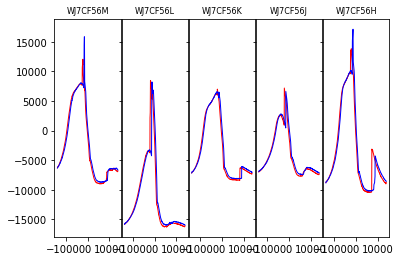

In [65]:
rnum_fig=int(math.floor(samplesize/5))  
fig, ax = plt.subplots(rnum_fig,5,sharex=True, sharey=True,squeeze=True)           # subplotSSSSSSSSSSS!
    
df2=dfb.groupby('Direction')


#plt.setp(ax,  xticklabels=[-10000,0,10000])
#ig.tight_layout()

#fig, axs = plt.subplots(rnum_fig,5, figsize=(20, 20), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .5, wspace=.001)

for i, a in enumerate(ax.flatten()):  
   

    df2=dfb[dfb['Dev']==(i+1)]  
    id=df2.iloc[0,3]
    
    grp1=df2.groupby(["Direction"]).get_group('rev')
    grp2=df2.groupby(["Direction"]).get_group('fwd')
    
    H50=sumdf[sumdf.SR==id].H50_corr    
    P1_BJ= sumdf[sumdf.SR==id].P1_BJ  
    P1_MAX= sumdf[sumdf.SR==id].P1_max  
    P1_RESULT= sumdf[sumdf.SR==id].P1_Result
    H50_RESULT= sumdf[sumdf.SR==id].H50_Result  
    
    
    dfx=grp1["Field"]
    dfy=grp1["Amp"]                      
    dfx2=grp2["Field"]
    dfy2=grp2["Amp"]           
 
    a.plot(dfx, dfy,'r',linewidth=1)
    a.plot(dfx2,dfy2,'b',linewidth=1)
   # a.axvline(x=H50_RESULT, color='y', linestyle='--')
#     a.axvline(x=P1_RESULT, color='y', linestyle='--')
    print  H50_RESULT
    
  
        
    a.set_title(id,fontsize=8 )
  #  a.grid(which='both')
    a.set_xticks([-10000,0,10000])    
   
plt.subplots_adjust( wspace=0.01, hspace=0.3)
plt.show()